### Feature Engineering

* Preceding Load: Previous `n` hours of actual load
* ~Temperature Changes: Previous `n` hours of temperature changes~
* ~Discomfort level~


---
**How to we the belief that the space of functions is in a neighborhood of the historical functions?**

Turn this subjective prior into an empirical one? Load is monotonic on certain
intervals, e.g. from overnight low to daily peak.

Create a daily cubic spline model for every historical day using hourly actual
load as control points. Cluster days according to coefficients in this model. 

Feature: Empirical probability that the current hours is peak.

Feature: Last `n` hours of temperature changes

---

In [1]:
%load_ext autoreload
%autoreload 2

from validation import DataSet

ds = DataSet('data/zone1.parquet', mtlf='LRZ1 MTLF (MWh)', actual='LRZ1 ActualLoad (MWh)')

ds.data.head()

,MSP,DayOfYear,HourEnding,IsBusinessHour,LRZ1 MTLF (MWh),LRZ1 ActualLoad (MWh)
hour,,,,,,
2015-02-01 00:00:00-05:00,23.00,32,1,0,11099,11337.89
2015-02-01 01:00:00-05:00,21.02,32,2,0,10829,11014.87
2015-02-01 02:00:00-05:00,19.04,32,3,0,10565,10795.37
2015-02-01 03:00:00-05:00,19.04,32,4,0,10468,10714.42
2015-02-01 04:00:00-05:00,17.06,32,5,0,10432,10700.09


### Feature: Preceding `n` Hours of Actual Load

In [83]:
feature_names = ds.features.copy()
X = ds.data[feature_names].copy()
y = ds.data[ds.actual].copy()

num_hours_prior = 32
def prior_load_colname(i : int):
    return f"Actual Load {i} hours prior"

for i in range(num_hours_prior, 0, -1):
    col_name = prior_load_colname(i)
    X[col_name] = y.shift(i)
    feature_names.append(col_name)

# shift the beginning of our data by `num_hours_prior`
# our train/validate/test split allows the training set time period
# to change while the validate and test are both fixed to a year
X = X[num_hours_prior:]
y = y[num_hours_prior:]
X.head()

,MSP,DayOfYear,HourEnding,IsBusinessHour,Actual Load 32 hours prior,Actual Load 31 hours prior,Actual Load 30 hours prior,Actual Load 29 hours prior,Actual Load 28 hours prior,Actual Load 27 hours prior,Actual Load 26 hours prior,Actual Load 25 hours prior,Actual Load 24 hours prior,Actual Load 23 hours prior,Actual Load 22 hours prior,Actual Load 21 hours prior,Actual Load 20 hours prior,Actual Load 19 hours prior,Actual Load 18 hours prior,Actual Load 17 hours prior,Actual Load 16 hours prior,Actual Load 15 hours prior,Actual Load 14 hours prior,Actual Load 13 hours prior,Actual Load 12 hours prior,Actual Load 11 hours prior,Actual Load 10 hours prior,Actual Load 9 hours prior,Actual Load 8 hours prior,Actual Load 7 hours prior,Actual Load 6 hours prior,Actual Load 5 hours prior,Actual Load 4 hours prior,Actual Load 3 hours prior,Actual Load 2 hours prior,Actual Load 1 hours prior
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-02 08:00:00-05:00,1.04,33,9,0,11337.89,11014.87,10795.37,10714.42,10700.09,10765.42,10977.36,11320.16,11744.05,12071.10,12328.69,12354.67,12332.78,12365.80,12244.04,12117.53,12081.32,12301.19,12865.14,13083.05,12918.00,12709.36,12497.52,12059.09,11728.11,11444.38,11235.13,11156.19,11166.90,11411.51,12075.09,13281.14
2015-02-02 09:00:00-05:00,1.04,33,10,1,11014.87,10795.37,10714.42,10700.09,10765.42,10977.36,11320.16,11744.05,12071.10,12328.69,12354.67,12332.78,12365.80,12244.04,12117.53,12081.32,12301.19,12865.14,13083.05,12918.00,12709.36,12497.52,12059.09,11728.11,11444.38,11235.13,11156.19,11166.90,11411.51,12075.09,13281.14,13890.16
2015-02-02 10:00:00-05:00,1.94,33,11,1,10795.37,10714.42,10700.09,10765.42,10977.36,11320.16,11744.05,12071.10,12328.69,12354.67,12332.78,12365.80,12244.04,12117.53,12081.32,12301.19,12865.14,13083.05,12918.00,12709.36,12497.52,12059.09,11728.11,11444.38,11235.13,11156.19,11166.90,11411.51,12075.09,13281.14,13890.16,13705.70
2015-02-02 11:00:00-05:00,5.00,33,12,1,10714.42,10700.09,10765.42,10977.36,11320.16,11744.05,12071.10,12328.69,12354.67,12332.78,12365.80,12244.04,12117.53,12081.32,12301.19,12865.14,13083.05,12918.00,12709.36,12497.52,12059.09,11728.11,11444.38,11235.13,11156.19,11166.90,11411.51,12075.09,13281.14,13890.16,13705.70,13596.18
2015-02-02 12:00:00-05:00,8.06,33,13,1,10700.09,10765.42,10977.36,11320.16,11744.05,12071.10,12328.69,12354.67,12332.78,12365.80,12244.04,12117.53,12081.32,12301.19,12865.14,13083.05,12918.00,12709.36,12497.52,12059.09,11728.11,11444.38,11235.13,11156.19,11166.90,11411.51,12075.09,13281.14,13890.16,13705.70,13596.18,13525.34


In [74]:
from validation import Error, walkforward
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(7, weights='distance')

def next_hour(actual, previous_hour, predicted_load):
    next = actual.copy()
    # HACK: assume the temps are forecasted...
    for i in range(num_hours_prior, 1, -1):
        next[prior_load_colname(i)] = previous_hour[prior_load_colname(i-1)].iloc[0]

    next[prior_load_colname(1)] = predicted_load
    return next

(predictions, errors) = walkforward(knn, X, y,
                                    ds.validation_start, ds.validation_end, next_hour)
overall_error = Error(ds.validation_data[ds.actual], np.concatenate(predictions))
print(overall_error)

Error(mae=637.164282724308, max=4027.4830035610703, total=5581559.116664948)


In [75]:
(predictions, errors) = walkforward(knn, X.drop(['MSP'], axis=1), y,
                                    ds.validation_start, ds.validation_end, next_hour)
overall_error = Error(ds.validation_data[ds.actual], np.concatenate(predictions))
print(overall_error)

Error(mae=636.6924075423867, max=4026.9788601493, total=5577425.490071278)


At least for our naive similarity model, temperature deosn't seem to matter much.

In [78]:
from sklearn.feature_selection import r_regression
r_regression(ds.train_data[['MSP']], ds.train_data[ds.actual])

array([-0.07044126])

In [117]:
sorted([(X.columns[i], v) for (i,v) in enumerate(r_regression(X[:ds.train_end], y[:ds.train_end]))], key=lambda r: -r[1])

[('Actual Load 1 hours prior', 0.9698708392592658),
 ('Actual Load 2 hours prior', 0.8908018194871311),
 ('Actual Load 24 hours prior', 0.8826428493634659),
 ('Actual Load 23 hours prior', 0.8595862452472319),
 ('Actual Load 25 hours prior', 0.8503471567758594),
 ('Actual Load 22 hours prior', 0.790784770318876),
 ('Actual Load 3 hours prior', 0.7813373717223855),
 ('Actual Load 26 hours prior', 0.7721270946412156),
 ('Actual Load 21 hours prior', 0.692821631825158),
 ('Actual Load 27 hours prior', 0.6645479816814707),
 ('Actual Load 4 hours prior', 0.6568357851679486),
 ('Actual Load 20 hours prior', 0.5800198696831458),
 ('Actual Load 28 hours prior', 0.5421580748867164),
 ('Actual Load 5 hours prior', 0.5301035726446124),
 ('Actual Load 19 hours prior', 0.46469888256616976),
 ('HourEnding', 0.44193192144989824),
 ('Actual Load 29 hours prior', 0.41765625501264064),
 ('Actual Load 6 hours prior', 0.4124904317770146),
 ('IsBusinessHour', 0.4012964105815318),
 ('Actual Load 18 hours pr

In [107]:
correlated_prior_hours = [1, 2, 23, 24, 25]
correlated_columns = [prior_load_colname(i) for i in correlated_prior_hours]
def next_hour(actual, previous_hour, predicted_load):
    next = actual.copy()
    next[prior_load_colname(1)] = predicted_load
    for i in correlated_prior_hours[1:]:
        next[prior_load_colname(i)] = previous_hour[prior_load_colname(i-1)].iloc[0]
    return next

knn = KNeighborsRegressor(6, weights='distance')
(predictions, errors) = walkforward(knn, X, y, ds.validation_start, ds.validation_end, next_hour,
                                    correlated_columns)
overall_error = Error(ds.validation_data[ds.actual], np.concatenate(predictions))
print(overall_error)

Error(mae=509.15754919719893, max=3403.1030505945346, total=4460220.130967453)


In [114]:
uncorrelated_features = ['DayOfYear', 'IsBusinessHour', 'HourEnding']
(predictions, errors) = walkforward(knn, X, y, ds.validation_start, ds.validation_end, next_hour,
                                    correlated_columns + uncorrelated_features)
overall_error = Error(ds.validation_data[ds.actual], np.concatenate(predictions))
print(overall_error)

Error(mae=514.997117494993, max=3426.9405375365604, total=4511374.749256153)


In [112]:
mtlf_error = Error(ds.validation_data[ds.actual], ds.validation_data[ds.mtlf])
print(f'MTLF {mtlf_error}')

MTLF Error(mae=222.98570091324197, max=2217.33, total=1953354.7399999993)


Our naive model still does not perform well. We are about 2.5x worse on the MTLF MAE and 1.5x worse on the maximum error.

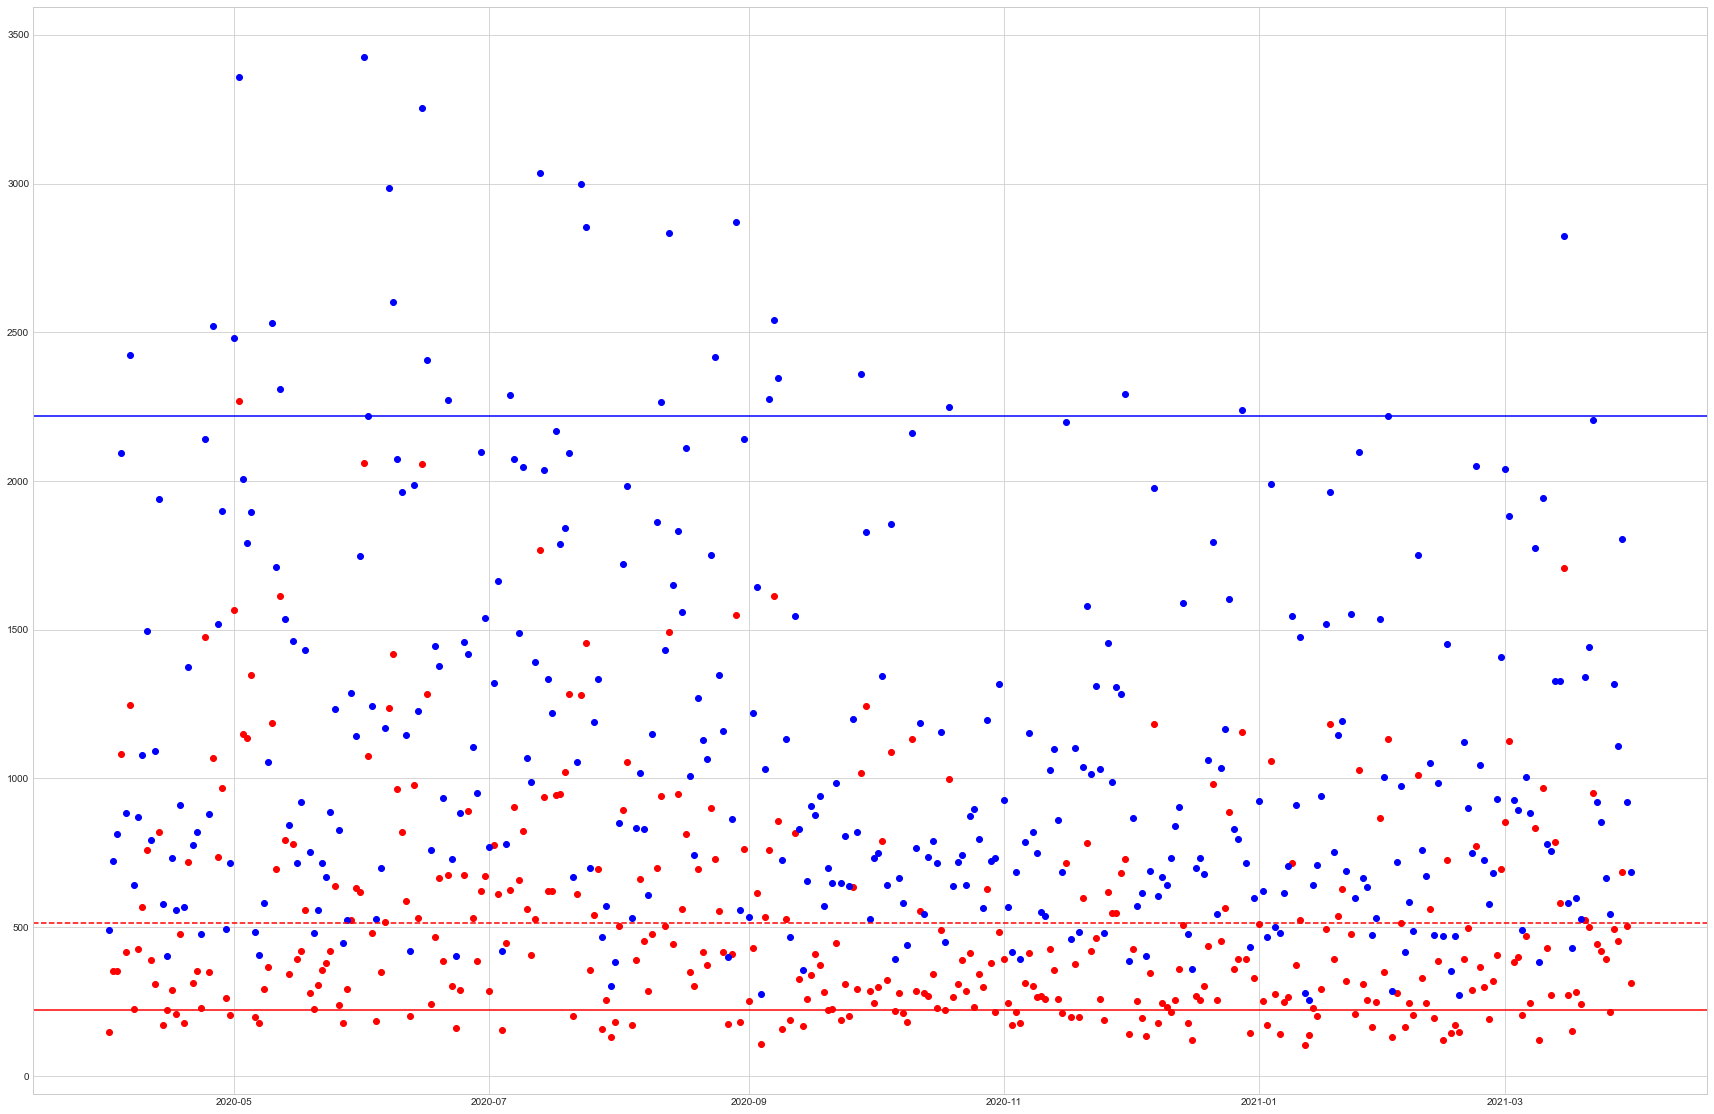

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

mae = [e.mae for e in errors]
maxe = [e.max for e in errors]
dates = ds.validation_data.index.to_series()[::24].array
plt.figure(figsize=(30, 20))
plt.plot(dates, mae, 'ro', dates, maxe, 'bo')
plt.axhline(y=mtlf_error.mae, color='r', linestyle='-')
plt.axhline(y=overall_error.mae, color='r', linestyle='--')
plt.axhline(y=mtlf_error.max, color='b', linestyle='-')
plt.show()

### Observations and Next Steps

The limits of our naive model are apparent. In the next notebook, we will explore linear models.